##### 三类股票分类，
##### 使用未来三天的平均change来作为标签值y，并用0.33, 0.67分位值作为三类标签的划分边界

##### 数据: 基本指标 
##### 模型:  LSTM


In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import row_stack,column_stack
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY,YEARLY
# from mpl_finance import quotes_historical_yahoo_ohlc, candlestick_ohlc
from matplotlib.pylab import date2num
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation,Dropout
import tushare as ts
import datetime
import time

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### softmax三类分类写不出来，用回归代替

### 加工数据

In [2]:
ts.set_token('29ea8fa19e717f1a3d3618796f87067ee07219783a9e01422eb90ef8')
pro = ts.pro_api()

df = pro.daily(ts_code='601318.SH', start_date = '20110101', end_date = '20181118')
df = df.iloc[::-1]
df.head()

df.to_csv('601318SH-from-20110101-to-20181118.csv', index=False)

df = pd.read_csv('601318SH-from-20110101-to-20181118.csv')
df.head()

input_data = df[[ 'open','high','low','pre_close','change','pct_chg','vol','amount','close']]


In [3]:
df.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,601318.SH,20110104,56.85,57.60,56.50,56.91,56.16,0.75,1.34,245626.82,1400499.338
1,601318.SH,20110105,56.59,56.80,54.80,54.86,56.91,-2.05,-3.60,427554.25,2368305.774
2,601318.SH,20110106,54.94,54.94,51.45,52.59,54.86,-2.27,-4.14,947078.65,4971851.955
3,601318.SH,20110107,52.97,54.25,51.80,53.01,52.59,0.42,0.80,659013.87,3494756.547
4,601318.SH,20110110,52.90,53.90,51.90,52.03,53.01,-0.98,-1.85,282919.36,1494174.281


In [4]:
# input_data['change'].quantile([0.33,0.5, 0.67,])
quantile033 = input_data['change'].quantile([0.33]).iloc[0]
quantile067 = input_data['change'].quantile([0.67]).iloc[0]

In [5]:
quantile033, quantile067

(-0.24, 0.25360000000000127)

In [6]:
input_data['change'].median()

0.01

In [7]:
data = input_data['change'].quantile([0.33,])

In [8]:
data.iloc[0]

-0.24

In [9]:
change = input_data['change']

In [10]:
ave_change_column = [ ]
for i in range(0, len(change)):
    if i >= len(change) - 3:
        ave_change = change[i]
        
    else:
        ave_change = (change[i+1] + change[i+2] + change[i+3]) / 3
    
    ave_change_column.append(ave_change)



In [11]:
len(change) , len(ave_change_column)

(1909, 1909)

In [12]:
input_data['ave_change'] = ave_change_column

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
input_data.head(5)

,open,high,low,pre_close,change,pct_chg,vol,amount,close,ave_change
0,56.85,57.60,56.50,56.16,0.75,1.34,245626.82,1400499.338,56.91,-1.300000
1,56.59,56.80,54.80,56.91,-2.05,-3.60,427554.25,2368305.774,54.86,-0.943333
2,54.94,54.94,51.45,54.86,-2.27,-4.14,947078.65,4971851.955,52.59,-0.156667
3,52.97,54.25,51.80,52.59,0.42,0.80,659013.87,3494756.547,53.01,-0.006667
4,52.90,53.90,51.90,53.01,-0.98,-1.85,282919.36,1494174.281,52.03,0.316667


In [14]:
data = input_data.values

dd1=input_data.sort_index()

dd2=dd1.values.flatten()

dd3=pd.DataFrame(dd1['close'])

In [15]:
def load_data(df, sequence_length=10, split=0.8):
    
    
    # 转为float型
    data_all = np.array(df.astype(float))
    # 标准化
    x_scaler = MinMaxScaler()
    data_all[:, :-1] = x_scaler.fit_transform(data_all[:, :-1])
    data = []
    for i in range(len(data_all) - sequence_length - 1):
        data.append(data_all[i: i + sequence_length + 1])
    reshaped_data = np.array(data).astype('float64')
    x = reshaped_data[:, :-1]
    y = reshaped_data[:, -1][:, -1]
    scaler = MinMaxScaler()
    y = scaler.fit_transform(y.reshape(-1, 1))
    split_boundary = int(reshaped_data.shape[0] * split)
    train_x = x[: split_boundary]
    test_x = x[split_boundary:]

    train_y = y[: split_boundary]
    test_y = y[split_boundary:]

    return train_x, train_y, test_x, test_y, scaler

In [16]:
# 添加自定义评价函数

# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))



In [17]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.5))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="adam", metrics=['accuracy','mean_squared_error',rmse, r_square])
    print("Compilation Time : ", time.time() - start)
    return model

In [18]:
def train_model(train_x, train_y, test_x, test_y):
    model = build_model([train_x.shape[2], train_x.shape[1], 200, 1])

    try:
        result  = model.fit(train_x, train_y, batch_size=40, nb_epoch=200, validation_split=0.1)
        predict = model.predict(test_x)
        predict = np.reshape(predict, (predict.size, ))
    except KeyboardInterrupt:
        print(predict)
        print(test_y)
#     print(predict)
#     print(test_y)
    try:
        fig = plt.figure(1)
        plt.plot(predict, 'r:')
        plt.plot(test_y, 'g-')
        plt.legend(['predict', 'true'])
    except Exception as e:
        print(e)
    return predict, test_y , model, result 

In [19]:
dd1.shape

(1909, 10)

In [21]:
train_x, train_y, test_x, test_y, scaler =load_data(dd1, sequence_length=10, split=0.88)

In [22]:
print("train_x", train_x.shape)
print("train_y", train_y.shape)
print("test_x", test_x.shape)
print("test_y", test_y.shape)

train_x (1670, 10, 10)
train_y (1670, 1)
test_x (228, 10, 10)
test_y (228, 1)


d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 10), units=10)`
  
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Compilation Time :  0.061834096908569336
Train on 1503 samples, validate on 167 samples
Epoch 1/200
1503/1503 [==============================] - 4s 3ms/step - loss: 0.0458 - acc: 6.6534e-04 - mean_squared_error: 0.0458 - rmse: 0.1572 - r_square: -7.4956 - val_loss: 0.0107 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0107 - val_rmse: 0.0785 - val_r_square: -0.3684
Epoch 2/200
1503/1503 [==============================] - 2s 1ms/step - loss: 0.0135 - acc: 0.0000e+00 - mean_squared_error: 0.0135 - rmse: 0.0858 - r_square: -0.9218 - val_loss: 0.0090 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0090 - val_rmse: 0.0712 - val_r_square: -0.1205
Epoch 3/200
1503/1503 [==============================] - 2s 1ms/step - loss: 0.0120 - acc: 0.0000e+00 - mean_squared_error: 0.0120 - rmse: 0.0790 - r_square: -0.6909 - val_loss: 0.0081 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0081 - val_rmse: 0.0684 - val_r_square: -0.0044
Epoch 4/200
1503/1503 [==============================] - 2s 1ms

1503/1503 [==============================] - 1s 952us/step - loss: 0.0066 - acc: 0.0000e+00 - mean_squared_error: 0.0066 - rmse: 0.0576 - r_square: 0.0659 - val_loss: 0.0056 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0056 - val_rmse: 0.0555 - val_r_square: 0.3231
Epoch 30/200
1503/1503 [==============================] - 1s 969us/step - loss: 0.0070 - acc: 6.6534e-04 - mean_squared_error: 0.0070 - rmse: 0.0584 - r_square: 0.0037 - val_loss: 0.0057 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0057 - val_rmse: 0.0557 - val_r_square: 0.3140
Epoch 31/200
1503/1503 [==============================] - 1s 944us/step - loss: 0.0068 - acc: 0.0000e+00 - mean_squared_error: 0.0068 - rmse: 0.0579 - r_square: 0.0527 - val_loss: 0.0059 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0059 - val_rmse: 0.0578 - val_r_square: 0.2611
Epoch 32/200
1503/1503 [==============================] - 2s 1ms/step - loss: 0.0064 - acc: 6.6534e-04 - mean_squared_error: 0.0064 - rmse: 0.0562 - r_square: 0.

1503/1503 [==============================] - 1s 995us/step - loss: 0.0058 - acc: 0.0000e+00 - mean_squared_error: 0.0058 - rmse: 0.0520 - r_square: 0.2003 - val_loss: 0.0048 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0048 - val_rmse: 0.0512 - val_r_square: 0.4153
Epoch 59/200
1503/1503 [==============================] - 1s 987us/step - loss: 0.0058 - acc: 6.6534e-04 - mean_squared_error: 0.0058 - rmse: 0.0526 - r_square: 0.1801 - val_loss: 0.0052 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0052 - val_rmse: 0.0533 - val_r_square: 0.3708
Epoch 60/200
1503/1503 [==============================] - 1s 977us/step - loss: 0.0060 - acc: 6.6534e-04 - mean_squared_error: 0.0060 - rmse: 0.0523 - r_square: 0.1504 - val_loss: 0.0048 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0048 - val_rmse: 0.0518 - val_r_square: 0.4210
Epoch 61/200
1503/1503 [==============================] - 1s 968us/step - loss: 0.0059 - acc: 6.6534e-04 - mean_squared_error: 0.0059 - rmse: 0.0524 - r_square: 

Epoch 87/200
1503/1503 [==============================] - 1s 947us/step - loss: 0.0052 - acc: 6.6534e-04 - mean_squared_error: 0.0052 - rmse: 0.0480 - r_square: 0.2697 - val_loss: 0.0053 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0053 - val_rmse: 0.0546 - val_r_square: 0.3460
Epoch 88/200
1503/1503 [==============================] - 1s 955us/step - loss: 0.0052 - acc: 6.6534e-04 - mean_squared_error: 0.0052 - rmse: 0.0483 - r_square: 0.2626 - val_loss: 0.0054 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0054 - val_rmse: 0.0545 - val_r_square: 0.3461
Epoch 89/200
1503/1503 [==============================] - 1s 987us/step - loss: 0.0050 - acc: 6.6534e-04 - mean_squared_error: 0.0050 - rmse: 0.0483 - r_square: 0.2921 - val_loss: 0.0049 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0049 - val_rmse: 0.0517 - val_r_square: 0.4057
Epoch 90/200
1503/1503 [==============================] - 1s 960us/step - loss: 0.0051 - acc: 6.6534e-04 - mean_squared_error: 0.0051 - rmse: 0.0479

1503/1503 [==============================] - 1s 936us/step - loss: 0.0047 - acc: 6.6534e-04 - mean_squared_error: 0.0047 - rmse: 0.0458 - r_square: 0.3454 - val_loss: 0.0048 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0048 - val_rmse: 0.0518 - val_r_square: 0.3873
Epoch 116/200
1503/1503 [==============================] - 1s 937us/step - loss: 0.0044 - acc: 6.6534e-04 - mean_squared_error: 0.0044 - rmse: 0.0444 - r_square: 0.3756 - val_loss: 0.0042 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0042 - val_rmse: 0.0473 - val_r_square: 0.5032
Epoch 117/200
1503/1503 [==============================] - 1s 940us/step - loss: 0.0046 - acc: 6.6534e-04 - mean_squared_error: 0.0046 - rmse: 0.0454 - r_square: 0.3725 - val_loss: 0.0048 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0048 - val_rmse: 0.0522 - val_r_square: 0.3868
Epoch 118/200
1503/1503 [==============================] - 1s 949us/step - loss: 0.0044 - acc: 6.6534e-04 - mean_squared_error: 0.0044 - rmse: 0.0440 - r_squar

Epoch 144/200
1503/1503 [==============================] - 1s 915us/step - loss: 0.0035 - acc: 6.6534e-04 - mean_squared_error: 0.0035 - rmse: 0.0389 - r_square: 0.4993 - val_loss: 0.0033 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0033 - val_rmse: 0.0410 - val_r_square: 0.6022
Epoch 145/200
1503/1503 [==============================] - 1s 990us/step - loss: 0.0035 - acc: 6.6534e-04 - mean_squared_error: 0.0035 - rmse: 0.0389 - r_square: 0.4994 - val_loss: 0.0036 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0036 - val_rmse: 0.0431 - val_r_square: 0.5710
Epoch 146/200
1503/1503 [==============================] - 1s 942us/step - loss: 0.0035 - acc: 6.6534e-04 - mean_squared_error: 0.0035 - rmse: 0.0386 - r_square: 0.4927 - val_loss: 0.0039 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0039 - val_rmse: 0.0451 - val_r_square: 0.5243
Epoch 147/200
1503/1503 [==============================] - 2s 1ms/step - loss: 0.0035 - acc: 6.6534e-04 - mean_squared_error: 0.0035 - rmse: 0.03

Epoch 173/200
1503/1503 [==============================] - 1s 928us/step - loss: 0.0030 - acc: 6.6534e-04 - mean_squared_error: 0.0030 - rmse: 0.0369 - r_square: 0.5693 - val_loss: 0.0037 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0037 - val_rmse: 0.0439 - val_r_square: 0.5492
Epoch 174/200
1503/1503 [==============================] - 1s 971us/step - loss: 0.0033 - acc: 6.6534e-04 - mean_squared_error: 0.0033 - rmse: 0.0372 - r_square: 0.5216 - val_loss: 0.0037 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0037 - val_rmse: 0.0438 - val_r_square: 0.5464
Epoch 175/200
1503/1503 [==============================] - 2s 1ms/step - loss: 0.0031 - acc: 6.6534e-04 - mean_squared_error: 0.0031 - rmse: 0.0369 - r_square: 0.5311 - val_loss: 0.0044 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0044 - val_rmse: 0.0491 - val_r_square: 0.4527
Epoch 176/200
1503/1503 [==============================] - 2s 1ms/step - loss: 0.0032 - acc: 6.6534e-04 - mean_squared_error: 0.0032 - rmse: 0.0376

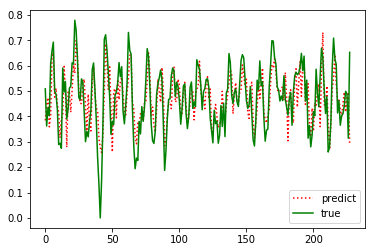

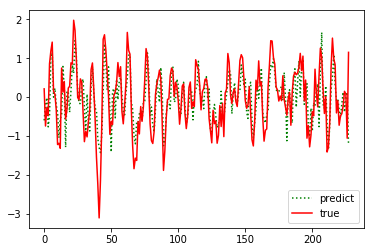

In [23]:
predict_y, test_y, model,result = train_model(train_x, train_y, test_x, test_y)
predict_y = scaler.inverse_transform([[i] for i in predict_y])
test_y = scaler.inverse_transform(test_y)
fig2 = plt.figure(2)
plt.plot(predict_y, 'g:')
plt.plot(test_y, 'r-')
plt.legend(['predict', 'true'])
plt.show()


In [24]:
# wx, gtk, osx, tk, empty uses default
%matplotlib qt
plt.clf()
# fig2 = plt.figure()
plt.plot(predict_y, 'b-',label = 'predict ave change')
plt.plot(test_y, 'r-', label = 'true ave change')
plt.title('601318SH Pingan Financial Group change price prediction')
plt.xlabel('Days')
plt.ylabel('change price')
plt.legend()
plt.show()



In [24]:
trend_list = [1,]
for i in range(1, len(predict_y)):
    if predict_y[i] <= quantile033:
        trend_list.append(-1)
    elif quantile033 <= predict_y[i] <= quantile067:
        trend_list.append(0)
    else:
        trend_list.append(1)

real_trend_list = [1,]
for i in range(1, len(test_y)):
    if test_y[i] <= quantile033:
        real_trend_list.append(-1)
    elif quantile033 <= test_y[i] <= quantile067:
        real_trend_list.append(0)
    else:
        real_trend_list.append(1)
        


true_count = 0
false_count = 0


print(len(test_y), len(predict_y))

pair_list = []

for i in range(len(predict_y)-1):
    pair_list.append([real_trend_list[i], trend_list[i]])
    if real_trend_list[i] == trend_list[i]:
        true_count = true_count + 1
    else:
        false_count = false_count + 1

# print(pair_list)
print(true_count, false_count)


380 380
257 122


In [25]:
len(real_trend_list) , len(trend_list)

(380, 380)

In [26]:
accuracy = true_count/ len(predict_y)
accuracy

0.6763157894736842

In [27]:
from collections import Counter

prediction_result = Counter(trend_list)
print ("预测数据", result)
prediction_result = Counter(real_trend_list)
print ("真实数据", result)

预测数据 <keras.callbacks.History object at 0x000001FA7B73DB38>
真实数据 <keras.callbacks.History object at 0x000001FA7B73DB38>


In [28]:
# count = 0
# for i in predict_y:
#     if quantile033 < i < quantile067:
#         count += 1

# print(count)

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 10)          840       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 10)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               168800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 169,841
Trainable params: 169,841
Non-trainable params: 0
_________________________________________________________________


In [30]:
real_df = pd.DataFrame(real_trend_list)
pred_df = pd.DataFrame(trend_list)
acc_df = pd.concat((real_df[0],pred_df[0]), axis=1)
acc_df.head(5)

,0,0
0,1,1
1,0,0
2,0,0
3,0,0
4,1,0


In [31]:
temp_list = []
temp_df =  real_df[0] - pred_df[0]
for i in range(0, len(temp_df)):
    temp_list.append([i, temp_df[i]])

In [32]:
temp_list[0:10]

[[0, 0],
 [1, 0],
 [2, 0],
 [3, 0],
 [4, 1],
 [5, 0],
 [6, 0],
 [7, 0],
 [8, 0],
 [9, 0]]

In [53]:
len(temp_df)

380

In [52]:
temp_df.value_counts()

 0    257
 1     71
-1     44
 2      7
-2      1
Name: 0, dtype: int64

In [54]:
%matplotlib qt
plt.clf()
# plt.figure()
plt.scatter( *zip(*temp_list), )
# plt.scatter(real_df.index.values, pred_df[0],color='blue', marker='^')
# plt.scatter(real_df.index.values, real_df[0],color='red', marker='.')
plt.title('Trend Prediction Accuracy of 601318SH = {}'.format(accuracy))
plt.xlabel('Days')
plt.ylabel('Trend Prediction')
plt.show()

In [34]:
%matplotlib qt
plt.clf()
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [35]:
%matplotlib qt
plt.clf()
plt.plot(result.history['mean_squared_error'])
plt.plot(result.history['val_mean_squared_error'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
train_x.shape, test_x.shape , df.shape, input_data.shape

((1518, 10, 10), (380, 10, 10), (1909, 11), (1909, 10))

In [37]:
new_data = df.copy()
new_data['ave_change'] = input_data['ave_change']

In [38]:
new_data.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,ave_change
0,601318.SH,20110104,56.85,57.60,56.50,56.91,56.16,0.75,1.34,245626.82,1400499.338,-1.300000
1,601318.SH,20110105,56.59,56.80,54.80,54.86,56.91,-2.05,-3.60,427554.25,2368305.774,-0.943333
2,601318.SH,20110106,54.94,54.94,51.45,52.59,54.86,-2.27,-4.14,947078.65,4971851.955,-0.156667
3,601318.SH,20110107,52.97,54.25,51.80,53.01,52.59,0.42,0.80,659013.87,3494756.547,-0.006667
4,601318.SH,20110110,52.90,53.90,51.90,52.03,53.01,-0.98,-1.85,282919.36,1494174.281,0.316667


In [39]:
new_data['ave_change'].iloc[1528:].head(20)

1528   -0.046667
1529   -0.216667
1530   -0.070000
1531    0.056667
1532    0.860000
1533    0.660000
1534    0.986667
1535    0.353333
1536    0.440000
1537   -0.176667
1538   -0.093333
1539   -0.026667
1540    0.806667
1541    0.850000
1542    0.673333
1543    0.883333
1544    0.670000
1545    0.680000
1546    0.160000
1547   -0.073333
Name: ave_change, dtype: float64

In [40]:
test_y[0:20] , predict_y[0:5]

(array([[-0.04666667],
        [-0.21666667],
        [-0.07      ],
        [ 0.05666667],
        [ 0.86      ],
        [ 0.66      ],
        [ 0.98666667],
        [ 0.35333333],
        [ 0.44      ],
        [-0.17666667],
        [-0.09333333],
        [-0.02666667],
        [ 0.80666667],
        [ 0.85      ],
        [ 0.67333333],
        [ 0.88333333],
        [ 0.67      ],
        [ 0.68      ],
        [ 0.16      ],
        [-0.07333333]]), array([[-0.00761507],
        [-0.07022592],
        [-0.21626616],
        [-0.00226721],
        [ 0.21084011]]))

In [41]:
save_data = new_data[1528:-1]

In [42]:
save_data.shape , test_x.shape, predict_y.shape , len(trend_list), len(real_trend_list)

((380, 12), (380, 10, 10), (380, 1), 380, 380)

In [43]:
save_data['pred_ave_change'] = predict_y

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
save_data['real_trend'] = real_trend_list
save_data['pred_trend'] = trend_list

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
save_data.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,ave_change,pred_ave_change,real_trend,pred_trend
1528,601318.SH,20170428,37.90,38.07,37.61,37.96,37.82,0.14,0.37,678663.87,2568647.819,-0.046667,-0.007615,1,1
1529,601318.SH,20170502,37.80,38.38,37.80,37.91,37.96,-0.05,-0.13,619325.39,2359210.184,-0.216667,-0.070226,0,0
1530,601318.SH,20170503,37.95,38.28,37.82,38.00,37.91,0.09,0.24,505383.86,1920918.772,-0.070000,-0.216266,0,0
1531,601318.SH,20170504,37.95,38.10,37.73,37.82,38.00,-0.18,-0.47,548573.55,2080732.893,0.056667,-0.002267,0,0
1532,601318.SH,20170505,37.70,37.86,37.20,37.26,37.82,-0.56,-1.48,623979.60,2337681.712,0.860000,0.210840,1,0


In [46]:
save_data.to_csv('Result-Pingan-from-20110101-to-20181118.csv', index=False)

In [47]:
save_data.pop('pred_ave_change')

1528   -0.007615
1529   -0.070226
1530   -0.216266
1531   -0.002267
1532    0.210840
1533    0.611569
1534    0.581645
1535    0.268698
1536    0.370684
1537   -0.008500
1538   -0.230298
1539   -0.150035
1540    0.162737
1541    0.683848
1542    0.707318
1543    0.017456
1544    0.661369
1545    0.646607
1546   -0.248776
1547    0.174148
1548   -0.035105
1549   -0.385505
1550    0.250812
1551    0.421082
1552    0.437751
1553    0.577631
1554    0.320854
1555    0.072707
1556   -0.586908
1557   -0.670483
          ...   
1878   -0.829226
1879   -0.236265
1880   -0.707561
1881   -0.080949
1882   -0.048187
1883    0.155490
1884    0.253537
1885   -0.733713
1886    0.648135
1887    1.548989
1888   -0.191912
1889   -0.308765
1890    0.128473
1891   -0.367033
1892   -1.185533
1893   -0.631756
1894    0.372763
1895    0.547336
1896    0.863067
1897    0.457024
1898   -0.176415
1899   -0.198674
1900   -0.280669
1901   -0.464033
1902   -0.308840
1903    0.113791
1904   -0.256374
1905   -0.0264

In [48]:
save_data.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,ave_change,real_trend,pred_trend
1528,601318.SH,20170428,37.90,38.07,37.61,37.96,37.82,0.14,0.37,678663.87,2568647.819,-0.046667,1,1
1529,601318.SH,20170502,37.80,38.38,37.80,37.91,37.96,-0.05,-0.13,619325.39,2359210.184,-0.216667,0,0
1530,601318.SH,20170503,37.95,38.28,37.82,38.00,37.91,0.09,0.24,505383.86,1920918.772,-0.070000,0,0
1531,601318.SH,20170504,37.95,38.10,37.73,37.82,38.00,-0.18,-0.47,548573.55,2080732.893,0.056667,0,0
1532,601318.SH,20170505,37.70,37.86,37.20,37.26,37.82,-0.56,-1.48,623979.60,2337681.712,0.860000,1,0
